In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

from utils.utils import run_model
from utils.visualize import visualize_latent_2d, visualize_interv
from utils.interventions import diff_interv

from models.ccvae import CCVAE
from models.baselines.cvae import CVAE
from models.baselines.vae import VAE

In [2]:
is_high = 1

train_dataset = torch.load('../eegVAE/train_dataset_id' + ('_high' if is_high else ''))
test_dataset = torch.load('../eegVAE/test_dataset_id' + ('_high' if is_high else ''))

In [3]:
to_shuffle = 1

dataset = train_dataset + test_dataset
random.shuffle(dataset)

In [4]:
n = int(0.8*len(dataset))

train_dataset = dataset[:n]
test_dataset = dataset[n:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 11025
Number of test graphs: 2757


In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=False)

## CCVAEs

In [6]:
z_dim = 5
num_classes = 3
use_cuda = True
p_dropout = 0.0
beta = 10000

In [7]:
model = CCVAE(z_dim, num_classes, use_cuda, 'FC', p_dropout, beta)

### Train

In [8]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [9]:
run_model(model, train_loader, test_loader, optim, n_epochs = 30)

Epoch: 0, Train acc: [0.51, 0.64, 0.7], Test acc: [0.51, 0.65, 0.68]
Epoch: 1, Train acc: [0.51, 0.82, 0.91], Test acc: [0.51, 0.83, 0.91]
Epoch: 2, Train acc: [0.5, 0.89, 0.91], Test acc: [0.51, 0.88, 0.91]
Epoch: 3, Train acc: [0.5, 0.91, 0.92], Test acc: [0.5, 0.9, 0.93]
Epoch: 4, Train acc: [0.51, 0.93, 0.96], Test acc: [0.51, 0.93, 0.96]
Epoch: 5, Train acc: [0.5, 0.95, 0.97], Test acc: [0.51, 0.94, 0.97]
Epoch: 6, Train acc: [0.51, 0.94, 0.96], Test acc: [0.51, 0.94, 0.96]
Epoch: 7, Train acc: [0.51, 0.97, 0.98], Test acc: [0.51, 0.96, 0.98]
Epoch: 8, Train acc: [0.52, 0.97, 0.99], Test acc: [0.51, 0.96, 0.98]
Epoch: 9, Train acc: [0.51, 0.98, 0.98], Test acc: [0.5, 0.97, 0.98]
Epoch: 10, Train acc: [0.52, 0.99, 0.99], Test acc: [0.53, 0.97, 0.98]
Epoch: 11, Train acc: [0.52, 0.98, 0.99], Test acc: [0.52, 0.97, 0.98]
Epoch: 12, Train acc: [0.51, 0.98, 0.98], Test acc: [0.5, 0.97, 0.98]
Epoch: 13, Train acc: [0.52, 1.0, 1.0], Test acc: [0.51, 0.98, 0.99]
Epoch: 14, Train acc: [0.5

### Visualize latent space

In [10]:
data = next(iter(test_loader))
xs, ys =  F.pad(input=data.adj, pad=(2, 1, 2, 1), mode='constant', value=0).unsqueeze(1).cuda(), data.y.cuda()

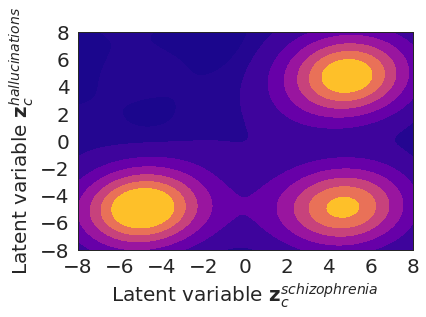

In [11]:
visualize_latent_2d(model, xs, 1, 2)

### Interventions

In [12]:
ind_to_vary = 2
label_values = torch.tensor([[1,1,1],[1,1,0]])
n_interventions = 1000

In [13]:
fc_diff = diff_interv(model, label_values, ind_to_vary, n_interventions = 1000)

In [14]:
for i,pair in enumerate(list(np.dstack(np.unravel_index(np.argsort(fc_diff.ravel()), (61, 61)))[0,-20:,:])[::-1]):
    if i % 2 == 0:
        print(str(np.loadtxt('/bigdata/hplsim/aipp/Maksim/EEG_data/Easycap_Koordinaten_61CH.txt', str)[:,3][pair]) + ': ' + str(fc_diff[pair[0], pair[1]])) 

['F4' 'F8']: 0.16602083
['F4' 'F6']: 0.15685809
['FT10' 'FT8']: 0.15530089
['F8' 'F6']: 0.15157387
['FC6' 'F8']: 0.14684263
['FT8' 'T8']: 0.14435415
['AF8' 'AF3']: 0.14265457
['FC6' 'FT8']: 0.14062689
['FC5' 'FT9']: 0.13609567
['F3' 'F7']: 0.13429095


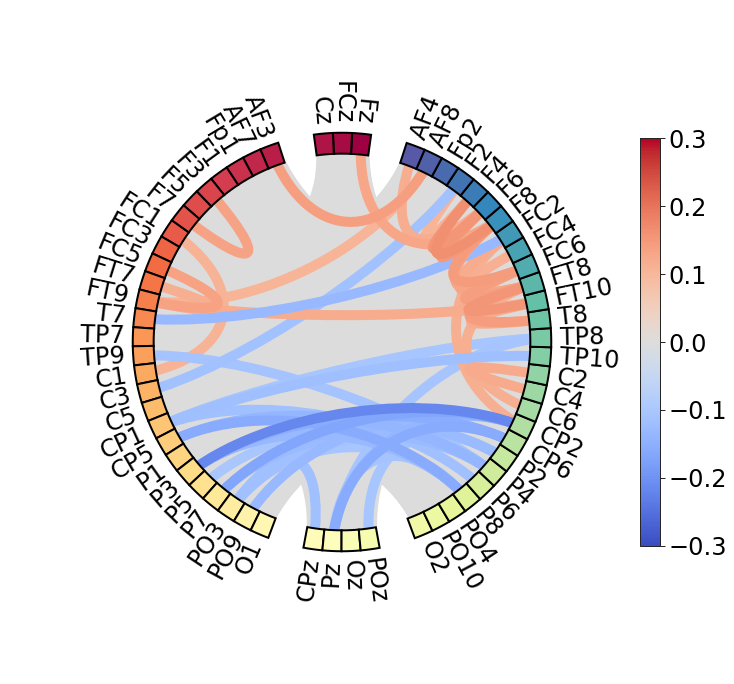

In [16]:
path = '/bigdata/hplsim/aipp/Maksim/EEG_data/Easycap_Koordinaten_61CH.txt'
visualize_interv(path, fc_diff, vmin = -0.3, vmax = 0.3)

# Baselines

## Conditional VAEs

In [18]:
z_dim = 5
num_classes = 3
use_cuda = True
p_dropout = 0.0
beta = 10000

In [19]:
model = CVAE(z_dim, num_classes, use_cuda, 'FC', p_dropout, beta)

### Train

In [20]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [21]:
run_model(model, train_loader, test_loader, optim, n_epochs = 30)

Epoch: 0, Train acc: [0.5, 0.42, 0.68], Test acc: [0.49, 0.41, 0.65]
Epoch: 1, Train acc: [0.5, 0.43, 0.67], Test acc: [0.49, 0.42, 0.65]
Epoch: 2, Train acc: [0.5, 0.43, 0.67], Test acc: [0.49, 0.42, 0.64]
Epoch: 3, Train acc: [0.5, 0.43, 0.67], Test acc: [0.49, 0.42, 0.64]
Epoch: 4, Train acc: [0.5, 0.44, 0.67], Test acc: [0.49, 0.42, 0.65]
Epoch: 5, Train acc: [0.5, 0.44, 0.66], Test acc: [0.49, 0.44, 0.64]
Epoch: 6, Train acc: [0.5, 0.43, 0.67], Test acc: [0.49, 0.43, 0.64]
Epoch: 7, Train acc: [0.5, 0.45, 0.67], Test acc: [0.49, 0.44, 0.64]
Epoch: 8, Train acc: [0.5, 0.45, 0.67], Test acc: [0.49, 0.46, 0.64]
Epoch: 9, Train acc: [0.5, 0.46, 0.66], Test acc: [0.49, 0.46, 0.63]
Epoch: 10, Train acc: [0.5, 0.47, 0.66], Test acc: [0.49, 0.45, 0.65]
Epoch: 11, Train acc: [0.5, 0.49, 0.65], Test acc: [0.49, 0.49, 0.63]
Epoch: 12, Train acc: [0.5, 0.47, 0.65], Test acc: [0.49, 0.49, 0.62]
Epoch: 13, Train acc: [0.5, 0.49, 0.63], Test acc: [0.49, 0.47, 0.61]
Epoch: 14, Train acc: [0.5, 0.

### Visualize latent space

In [22]:
data = next(iter(test_loader))
xs, ys =  F.pad(input=data.adj, pad=(2, 1, ß2, 1), mode='constant', value=0).unsqueeze(1).cuda(), data.y.cuda()

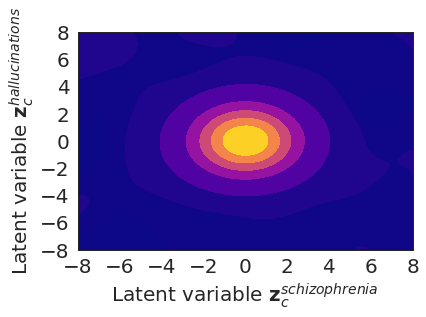

In [30]:
visualize_latent_2d(model, xs, 3, 2)

## VAEs + classification

In [24]:
z_dim = 5
num_classes = 3
use_cuda = True
p_dropout = 0.0
beta = 10000

In [25]:
model = VAE(z_dim, num_classes, use_cuda, 'FC', p_dropout, beta)

### Train

In [26]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [27]:
run_model(model, train_loader, test_loader, optim, n_epochs = 30)

Epoch: 0, Train acc: [0.5, 0.47, 0.7], Test acc: [0.5, 0.48, 0.67]
Epoch: 1, Train acc: [0.5, 0.62, 0.7], Test acc: [0.49, 0.63, 0.67]
Epoch: 2, Train acc: [0.5, 0.63, 0.7], Test acc: [0.49, 0.65, 0.67]
Epoch: 3, Train acc: [0.5, 0.63, 0.7], Test acc: [0.49, 0.65, 0.67]
Epoch: 4, Train acc: [0.5, 0.63, 0.7], Test acc: [0.48, 0.65, 0.67]
Epoch: 5, Train acc: [0.5, 0.63, 0.7], Test acc: [0.49, 0.65, 0.67]
Epoch: 6, Train acc: [0.5, 0.63, 0.7], Test acc: [0.49, 0.65, 0.67]
Epoch: 7, Train acc: [0.51, 0.63, 0.7], Test acc: [0.49, 0.65, 0.67]
Epoch: 8, Train acc: [0.5, 0.63, 0.7], Test acc: [0.49, 0.65, 0.67]
Epoch: 9, Train acc: [0.5, 0.63, 0.7], Test acc: [0.49, 0.65, 0.67]
Epoch: 10, Train acc: [0.5, 0.63, 0.7], Test acc: [0.5, 0.65, 0.67]
Epoch: 11, Train acc: [0.5, 0.63, 0.7], Test acc: [0.5, 0.65, 0.67]
Epoch: 12, Train acc: [0.5, 0.63, 0.7], Test acc: [0.49, 0.65, 0.67]
Epoch: 13, Train acc: [0.5, 0.63, 0.7], Test acc: [0.49, 0.65, 0.67]
Epoch: 14, Train acc: [0.5, 0.63, 0.7], Test a

### Visualize latent space

In [28]:
data = next(iter(test_loader))
xs, ys =  F.pad(input=data.adj, pad=(2, 1, 2, 1), mode='constant', value=0).unsqueeze(1).cuda(), data.y.cuda()

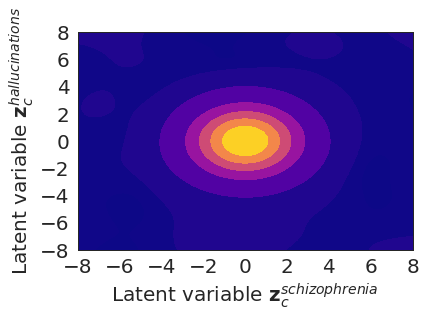

In [29]:
visualize_latent_2d(model, xs, 1, 2)